<a href="https://colab.research.google.com/github/ohikouta/deep-learning_pytorch_fastai/blob/main/ch04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4章 舞台裏：数字のクラス分類器

## 4.1 ピクセル：コンピュータビジョンの基礎

In [1]:
from fastai.vision.all import *
path = untar_data(URLs.MNIST_SAMPLE)

In [2]:
path.ls()

(#3) [Path('/root/.fastai/data/mnist_sample/labels.csv'),Path('/root/.fastai/data/mnist_sample/valid'),Path('/root/.fastai/data/mnist_sample/train')]

In [3]:
(path/'train').ls()

(#2) [Path('/root/.fastai/data/mnist_sample/train/7'),Path('/root/.fastai/data/mnist_sample/train/3')]

In [4]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('/root/.fastai/data/mnist_sample/train/3/10.png'),Path('/root/.fastai/data/mnist_sample/train/3/10000.png'),Path('/root/.fastai/data/mnist_sample/train/3/10011.png'),Path('/root/.fastai/data/mnist_sample/train/3/10031.png'),Path('/root/.fastai/data/mnist_sample/train/3/10034.png'),Path('/root/.fastai/data/mnist_sample/train/3/10042.png'),Path('/root/.fastai/data/mnist_sample/train/3/10052.png'),Path('/root/.fastai/data/mnist_sample/train/3/1007.png'),Path('/root/.fastai/data/mnist_sample/train/3/10074.png'),Path('/root/.fastai/data/mnist_sample/train/3/10091.png')...]

In [5]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3
im3.shape

(28, 28)

In [6]:
array(im3)[4:10, 4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [7]:
tensor(im3)[4:10, 4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [8]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15, 4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


In [9]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
print(len(three_tensors), len(seven_tensors))

6131 6265


AxesSubplot(0.125,0.125;0.775x0.755)


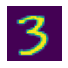

In [10]:
print(show_image(three_tensors[1]))

In [11]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
print(stacked_threes.shape, stacked_sevens.shape)

torch.Size([6131, 28, 28]) torch.Size([6265, 28, 28])


In [12]:
print(len(stacked_threes.shape))
print(stacked_threes.ndim)

3
3


AxesSubplot(0.125,0.125;0.775x0.755)


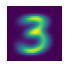

In [13]:
mean3 = stacked_threes.mean(0)
print(show_image(mean3))

AxesSubplot(0.125,0.125;0.775x0.755)


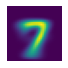

In [14]:
mean7 = stacked_sevens.mean(0)
print(show_image(mean7))

AxesSubplot(0.125,0.125;0.775x0.755)


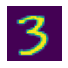

In [15]:
a_3 = stacked_threes[1]
print(show_image(a_3))

In [16]:
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs, dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [17]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs, dist_7_sqr

(tensor(0.1586), tensor(0.3021))

In [18]:
F.l1_loss(a_3.float(), mean7), F.mse_loss(a_3, mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

### 4.2.1 NumPy配列とPyTorchテンソル

In [19]:
data = [[1, 2, 3], [4, 5, 6]]
arr = array(data)
tns = tensor(data)
print(arr)  # numpy
print(tns)  # pytorch

[[1 2 3]
 [4 5 6]]
tensor([[1, 2, 3],
        [4, 5, 6]])


In [20]:
tns[1]

tensor([4, 5, 6])

In [21]:
tns[:, 1]

tensor([2, 5])

In [22]:
tns[1, 1:3]

tensor([5, 6])

In [23]:
tns+1

tensor([[2, 3, 4],
        [5, 6, 7]])

In [24]:
tns.type()

'torch.LongTensor'

In [25]:
type(tns)

torch.Tensor

In [26]:
tns*1.5

tensor([[1.5000, 3.0000, 4.5000],
        [6.0000, 7.5000, 9.0000]])

## 4.3 ブロードキャストを用いたメトリックの計算

In [27]:
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
print(valid_3_tens.shape, valid_7_tens.shape)

torch.Size([1010, 28, 28]) torch.Size([1028, 28, 28])


In [28]:
def mnist_distance(a, b): return (a-b).abs().mean((-1, -2))
mnist_distance(a_3, mean3)

tensor(0.1114)

In [29]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)
print(valid_3_dist)
print(valid_3_dist.shape)

tensor([0.1498, 0.1097, 0.1433,  ..., 0.1445, 0.1611, 0.1198])
torch.Size([1010])


In [30]:
tensor([1, 2, 3]) + tensor(1)

tensor([2, 3, 4])

In [31]:
(valid_3_tens-mean3).shape

torch.Size([1010, 28, 28])

In [32]:
def is_3(x):
  return mnist_distance(x, mean3) < mnist_distance(x, mean7)

In [33]:
print(is_3(a_3), is_3(a_3).float())

tensor(True) tensor(1.)


In [34]:
result = is_3(valid_3_tens)

In [35]:
valid_3_tens.shape[0] - len(result)

0

In [36]:
accuracy_3s = is_3(valid_3_tens).float().mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()
print(accuracy_3s, accuracy_7s, (accuracy_3s+accuracy_7s)/2)

tensor(0.9168) tensor(0.9854) tensor(0.9511)


## 4.4 確率的勾配降下法（SGD）

In [37]:
def pr_three(x, w): return (x*w).sum()

In [38]:
def f(x): return x**2

In [39]:
!pip install utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [40]:
import matplotlib.pyplot as plt
from utils import *
import inspect

In [41]:
xt = tensor(3.)
print(xt)

tensor(3.)


In [42]:
xt.requires_grad_()

tensor(3., requires_grad=True)

In [43]:
xt = xt.requires_grad_()

In [44]:
xt

tensor(3., requires_grad=True)

In [45]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

In [46]:
yt.backward()

In [47]:
xt.grad

tensor(6.)

In [48]:
xt = tensor([3., 4., 10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

In [49]:
def f(x): return (x**2).sum()

yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

In [50]:
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

In [51]:
time = torch.arange(0, 20).float()
time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19.])

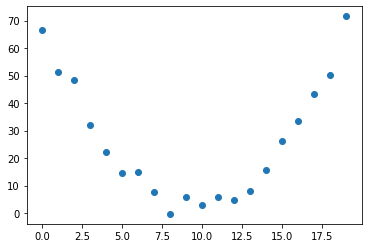

In [52]:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time, speed)

In [53]:
def f(t, params):
  a, b, c = params
  return a*(t**2) + (b*t) + c

In [54]:
def mse(preds, targets):
  return ((preds-targets)**2).mean()

In [55]:
params = torch.randn(3).requires_grad_()
print(params)

tensor([-0.9121, -0.4159,  0.4683], requires_grad=True)


In [56]:
preds = f(time, params)

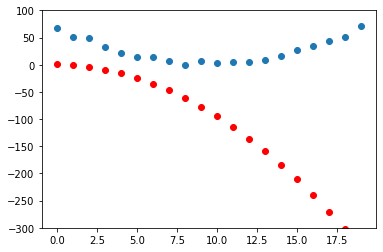

In [57]:
def show_preds(preds, ax=None):
  if ax is None: ax=plt.subplots()[1]
  ax.scatter(time, speed)
  ax.scatter(time, to_np(preds), color='red')
  ax.set_ylim(-300, 100)

show_preds(preds)

In [58]:
loss = mse(preds, speed)
loss

tensor(33129.9805, grad_fn=<MeanBackward0>)

In [59]:
loss.backward()
params.grad

tensor([-60491.8828,  -3887.1096,   -284.8268])

In [60]:
params.grad * 1e-5

tensor([-0.6049, -0.0389, -0.0028])

In [61]:
params

tensor([-0.9121, -0.4159,  0.4683], requires_grad=True)

In [62]:
lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None

In [63]:
preds = f(time, params)
mse(preds, speed)

tensor(6765.6221, grad_fn=<MeanBackward0>)

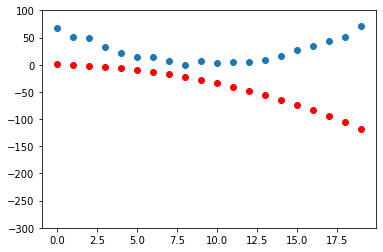

In [64]:
show_preds(preds)

In [65]:
def apply_step(params, prn=True):
  preds = f(time, params)
  loss = mse(preds, speed)
  loss.backward()
  params.data -= lr * params.grad.data
  params.grad = None
  if prn: print(loss.item())
  return preds

In [66]:
for i in range(10):
  apply_step(params)

6765.6220703125
1776.6761474609375
832.6126098632812
653.9638671875
620.155029296875
613.754150390625
612.539794921875
612.3069458007812
612.2597045898438
612.2476196289062


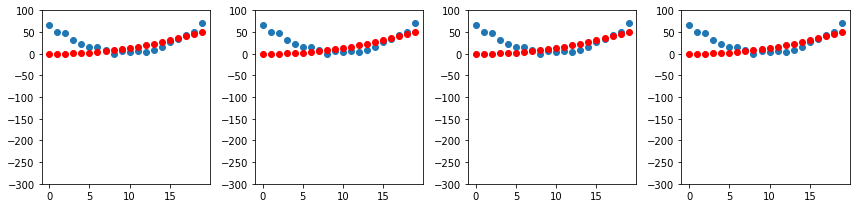

In [67]:
_, axs = plt.subplots(1, 4, figsize=(12, 3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

## 4.5 MNISTのロス関数

In [68]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

In [69]:
train_x.shape

torch.Size([12396, 784])

In [70]:
print(stacked_threes.shape)
print(stacked_sevens.shape)

torch.Size([6131, 28, 28])
torch.Size([6265, 28, 28])


In [71]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)

In [72]:
print(train_x.shape)
print(train_y.shape)

torch.Size([12396, 784])
torch.Size([12396, 1])


In [73]:
dset = list(zip(train_x, train_y))
x, y = dset[0] # 768のリスト, 1のリスト
x.shape, y

(torch.Size([784]), tensor([1]))

In [74]:
# 検証セットにも同じように
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x, valid_y))

In [75]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()
weights = init_params((28*28, 1))
bias = init_params(1)

In [76]:
weights.T.shape
(train_x[0]*weights.T).sum() + bias

tensor([-6.0778], grad_fn=<AddBackward0>)

In [77]:
def linear1(xb): 
  print(xb.shape)
  print(weights.shape)
  return xb@weights + bias
preds = linear1(train_x)
preds.shape
preds

torch.Size([12396, 784])
torch.Size([784, 1])


tensor([[ -6.0778],
        [  1.9493],
        [ -4.8041],
        ...,
        [ -0.8668],
        [-13.6783],
        [  8.4941]], grad_fn=<AddBackward0>)

In [78]:
corrects = (preds>0.0).float() == train_y
corrects

tensor([[False],
        [ True],
        [False],
        ...,
        [ True],
        [ True],
        [False]])

In [79]:
corrects.float().mean().item()

0.4443368911743164

In [80]:
trgts = tensor(1, 0, 1)
prds = tensor([0.9, 0.4, 0.2])

In [81]:
def mnist_loss(predictions, targets):
  return torch.where(targets==1, 1-predictions, predictions).mean()

In [82]:
torch.where(trgts==1, 1-prds, prds)

tensor([0.1000, 0.4000, 0.8000])

In [83]:
mnist_loss(prds, trgts)

tensor(0.4333)

In [84]:
mnist_loss(tensor([0.9, 0.4, 0.8]), trgts)

tensor(0.2333)

### 4.5.1 シグモイド

In [85]:
def sigmoid(x): return 1/(1+torch.exp(-x))

In [86]:
def mnist_loss(predictions, targets):
  predictions = predictions.sigmoid()
  return torch.where(targets==1, 1-predictions, predictions).mean()

### 4.5.2 SGDとミニバッチ

In [87]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)

In [88]:
dl

In [89]:
list(dl)

[tensor([ 0, 14,  3,  8, 10]),
 tensor([ 7,  1, 11,  5,  2]),
 tensor([13,  9,  6,  4, 12])]

In [90]:
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

In [91]:
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

[(tensor([ 1, 25,  9, 16, 10,  4]), ('b', 'z', 'j', 'q', 'k', 'e')),
 (tensor([ 0, 11,  3, 15,  8,  6]), ('a', 'l', 'd', 'p', 'i', 'g')),
 (tensor([23, 20, 18, 19,  5,  7]), ('x', 'u', 's', 't', 'f', 'h')),
 (tensor([21, 17,  2, 22, 24, 13]), ('v', 'r', 'c', 'w', 'y', 'n')),
 (tensor([12, 14]), ('m', 'o'))]

## 4.6 すべてをまとめる

In [92]:
weights = init_params((28*28, 1))
bias = init_params(1)

In [93]:
dl = DataLoader(dset, batch_size=256)

In [94]:
xb, yb = first(dl)

In [95]:
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [96]:
valid_dl = DataLoader(valid_dset, batch_size=256)

In [97]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [98]:
preds = linear1(batch)
preds

torch.Size([4, 784])
torch.Size([784, 1])


tensor([[-4.2673],
        [-5.1529],
        [-9.2072],
        [-6.3332]], grad_fn=<AddBackward0>)

In [99]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.9946, grad_fn=<MeanBackward0>)

In [100]:
loss.backward()
weights.grad.shape, weights.grad.mean(), bias.grad

(torch.Size([784, 1]), tensor(-0.0008), tensor([-0.0053]))

In [101]:
def calc_grad(xb, yb, model):
  preds = model(xb)
  loss = mnist_loss(preds, yb)
  loss.backward()

In [102]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(), bias.grad

torch.Size([4, 784])
torch.Size([784, 1])


(tensor(-0.0015), tensor([-0.0106]))

In [103]:
# 勾配を0にしなかった場合
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(), bias.grad

torch.Size([4, 784])
torch.Size([784, 1])


(tensor(-0.0023), tensor([-0.0159]))

In [104]:
# lossの前に勾配は0にしておかないと加算される
weights.grad.zero_()
bias.grad.zero_()

tensor([0.])

In [105]:
def train_epoch(model, lr, params):
  for xb, yb in dl:
    calc_grad(xb, yb, model)
    for p in params:
      for p in params:
        p.data -= p.grad*lr
        p.grad.zero_()

In [106]:
(preds>0.5).float() == train_y[:4]

tensor([[False],
        [False],
        [False],
        [False]])

In [107]:
def batch_accuracy(xb, yb):
  preds = xb.sigmoid()
  correct = (preds>0.5) == yb
  return correct.float().mean()

In [108]:
batch_accuracy(linear1(batch), train_y[:4])

torch.Size([4, 784])
torch.Size([784, 1])


tensor(0.)

In [109]:
def validate_epoch(model):
  accs = [batch_accuracy(model(xb), yb) for xb, yb in valid_dl]
  return round(torch.stack(accs).mean().item(), 4)

validate_epoch(linear1)

torch.Size([256, 784])
torch.Size([784, 1])
torch.Size([256, 784])
torch.Size([784, 1])
torch.Size([256, 784])
torch.Size([784, 1])
torch.Size([256, 784])
torch.Size([784, 1])
torch.Size([256, 784])
torch.Size([784, 1])
torch.Size([256, 784])
torch.Size([784, 1])
torch.Size([256, 784])
torch.Size([784, 1])
torch.Size([246, 784])
torch.Size([784, 1])


0.2433

In [110]:
lr = 1.
params = weights, bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

torch.Size([256, 784])
torch.Size([784, 1])
torch.Size([256, 784])
torch.Size([784, 1])
torch.Size([256, 784])
torch.Size([784, 1])
torch.Size([256, 784])
torch.Size([784, 1])
torch.Size([256, 784])
torch.Size([784, 1])
torch.Size([256, 784])
torch.Size([784, 1])
torch.Size([256, 784])
torch.Size([784, 1])
torch.Size([256, 784])
torch.Size([784, 1])
torch.Size([256, 784])
torch.Size([784, 1])
torch.Size([256, 784])
torch.Size([784, 1])
torch.Size([256, 784])
torch.Size([784, 1])
torch.Size([256, 784])
torch.Size([784, 1])
torch.Size([256, 784])
torch.Size([784, 1])
torch.Size([256, 784])
torch.Size([784, 1])
torch.Size([256, 784])
torch.Size([784, 1])
torch.Size([256, 784])
torch.Size([784, 1])
torch.Size([256, 784])
torch.Size([784, 1])
torch.Size([256, 784])
torch.Size([784, 1])
torch.Size([256, 784])
torch.Size([784, 1])
torch.Size([256, 784])
torch.Size([784, 1])
torch.Size([256, 784])
torch.Size([784, 1])
torch.Size([256, 784])
torch.Size([784, 1])
torch.Size([256, 784])
torch.Siz

0.6449

In [111]:
for i in range(20):
  train_epoch(linear1, lr, params)
  print(validate_epoch(linear1), end='')

torch.Size([256, 784])
torch.Size([784, 1])
torch.Size([256, 784])
torch.Size([784, 1])
torch.Size([256, 784])
torch.Size([784, 1])
torch.Size([256, 784])
torch.Size([784, 1])
torch.Size([256, 784])
torch.Size([784, 1])
torch.Size([256, 784])
torch.Size([784, 1])
torch.Size([256, 784])
torch.Size([784, 1])
torch.Size([256, 784])
torch.Size([784, 1])
torch.Size([256, 784])
torch.Size([784, 1])
torch.Size([256, 784])
torch.Size([784, 1])
torch.Size([256, 784])
torch.Size([784, 1])
torch.Size([256, 784])
torch.Size([784, 1])
torch.Size([256, 784])
torch.Size([784, 1])
torch.Size([256, 784])
torch.Size([784, 1])
torch.Size([256, 784])
torch.Size([784, 1])
torch.Size([256, 784])
torch.Size([784, 1])
torch.Size([256, 784])
torch.Size([784, 1])
torch.Size([256, 784])
torch.Size([784, 1])
torch.Size([256, 784])
torch.Size([784, 1])
torch.Size([256, 784])
torch.Size([784, 1])
torch.Size([256, 784])
torch.Size([784, 1])
torch.Size([256, 784])
torch.Size([784, 1])
torch.Size([256, 784])
torch.Siz

In [112]:
linear_model = nn.Linear(28*28, 1)

In [113]:
# parametersメソッドで内部訓練可能パラメータ参照
w, b = linear_model.parameters()
print(w.shape, b.shape)

torch.Size([1, 784]) torch.Size([1])


In [114]:
class BasicOptim:
  def __init__(self, params, lr): self.params, self.lr = list(params), lr

  def step(self, *args, **kwargs):
    for p in self.params: p.data -= p.grad.data*self.lr
  
  def zero_grad(self, *args, **kwargs):
    for p in self.params: p.grad = None

In [115]:
opt = BasicOptim(linear_model.parameters(), lr)

In [116]:
def train_epoch(model):
  for xb, yb in dl:
    calc_grad(xb, yb, model)
    opt.step()
    opt.zero_grad()

In [117]:
validate_epoch(linear_model)

0.5458

In [118]:
def train_model(model, epochs):
  for i in range(epochs):
    train_epoch(model)
    print(validate_epoch(model), end=" ")

In [119]:
train_model(linear_model, 20)

0.4932 0.855 0.8335 0.9116 0.9331 0.9482 0.956 0.9624 0.9653 0.9682 0.9697 0.9721 0.9741 0.9751 0.9761 0.9761 0.9775 0.978 0.978 0.9785 

In [120]:
linear_model = nn.Linear(28*28, 1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932 0.4932 0.6577 0.8682 0.918 0.936 0.9502 0.9565 0.9643 0.9658 0.9678 0.9702 0.9721 0.9741 0.9751 0.9761 0.9765 0.9775 0.978 0.9785 

In [121]:
dls = DataLoaders(dl, valid_dl)
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [122]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.636947,0.503431,0.495584,00:00
1,0.498895,0.187969,0.842493,00:00
2,0.183761,0.180524,0.838077,00:00
3,0.080955,0.106853,0.911187,00:00
4,0.043101,0.078138,0.933268,00:00
5,0.028327,0.062604,0.946025,00:00
6,0.022250,0.052881,0.954367,00:00
7,0.019546,0.046411,0.962218,00:00
8,0.018173,0.041881,0.965162,00:00
9,0.017347,0.038555,0.966634,00:00


## 4.7 非線形性を加える

In [123]:
def simple_net(xb):
  res = xb@w1 + b1
  res = res.max(tensor(0.0))
  res = res@w2 + b2
  return res

In [124]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

In [125]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [126]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.342250,0.399956,0.508341,00:00
1,0.153440,0.237684,0.795878,00:00
2,0.083607,0.117553,0.911678,00:00
3,0.054188,0.078648,0.942100,00:00
4,0.040670,0.061152,0.955348,00:00
5,0.033838,0.051414,0.963690,00:00
6,0.029960,0.045293,0.966143,00:00
7,0.027468,0.041117,0.966634,00:00
8,0.025687,0.038087,0.967615,00:00
9,0.024317,0.035776,0.971050,00:00


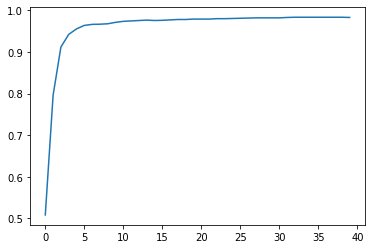

In [128]:
plt.plot(L(learn.recorder.values).itemgot(2))

In [129]:
learn.recorder.values[-1][2]

0.982826292514801

### 4.7.1 さらに深く

In [131]:
dls = ImageDataLoaders.from_folder(path)
learn = cnn_learner(dls, resnet18, pretrained=False,
                   loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:284: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


epoch,train_loss,valid_loss,accuracy,time
0,0.091265,0.016084,0.995584,00:24


## 4.8 用語の復習

## 4.9 問題

### 4.9.1 さらに詳しく